grayscale


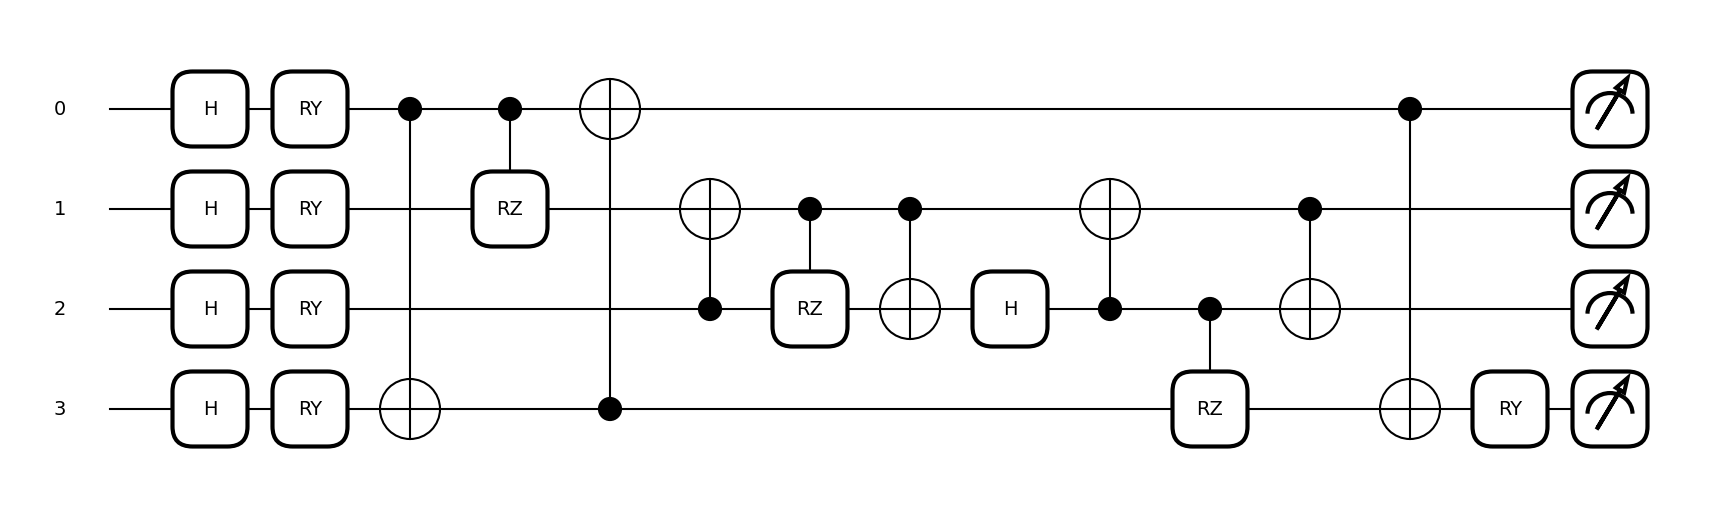

/var/folders/4y/fksy204x14b55bxyl0ytbjwm0000gn/T/ipykernel_32175/2918588388.py:61: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [3]:
%reset -f 
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

from torchvision.datasets import ImageFolder

import pennylane as qml
from pennylane import numpy as np
from tqdm import tqdm
from IPython.display import display, clear_output

from qugel.qgates import *

img_w = 256
rgb_c = 1  # Number of channels in the image (RGB)
n_qubits = 4
wires = n_qubits

num_classes = 2
n_layers = 1
phi_pqc_array = torch.tensor(np.pi * np.random.randn(n_qubits))

data_dir = "./datasets/ba"

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dev4 = qml.device("default.qubit", wires=n_qubits)

# Dataset and dataloader
transform_list = [transforms.Resize((img_w, img_w))]  # Resize images to a fixed size
if rgb_c == 1:
    transform_list.append(transforms.Grayscale())  # Convert images to grayscale
    print("grayscale")
transform_list.append(transforms.ToTensor())  # Convert images to tensors
data_transform = transforms.Compose(transform_list)
dataset = ImageFolder(data_dir, transform=data_transform)

@qml.qnode(dev4)
def CONVCircuit(inputs, params_arr, q_bits, q_depth):
    """
    Args:
        inputs: the image to encode.
        params: phie, the paramaters of the PQC to learn
    """
    num_rep = int(inputs.shape[0] / q_bits)
    Q_encoding_block(inputs, q_bits)

    Q_quanvol_block_A(params_arr, q_bits, q_depth)
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(wires)]
    # print("Patch:{}, Measure:{}, Reps:{}".format(inputs.shape, len(exp_vals), num_rep))
    return exp_vals

fig, ax = qml.draw_mpl(CONVCircuit, expansion_strategy='device')(phi_pqc_array,phi_pqc_array,n_qubits,n_layers)
# fig, ax = qml.draw_mpl(cirq_0, expansion_strategy='device')(3.14)
plt.show()
fig.show()


Img shape:torch.Size([1, 1, 256, 256])
Patch Size: 2, Total Patches: 16129


/var/folders/4y/fksy204x14b55bxyl0ytbjwm0000gn/T/ipykernel_32175/128953577.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  results[i // patch_size, j // patch_size] = torch.tensor(exp_vals)


Patch Size: 4, Total Patches: 3969
Patch Size: 8, Total Patches: 961


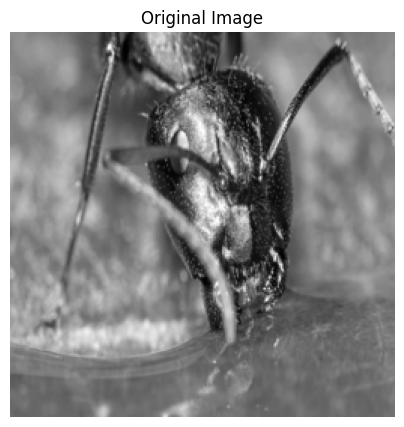

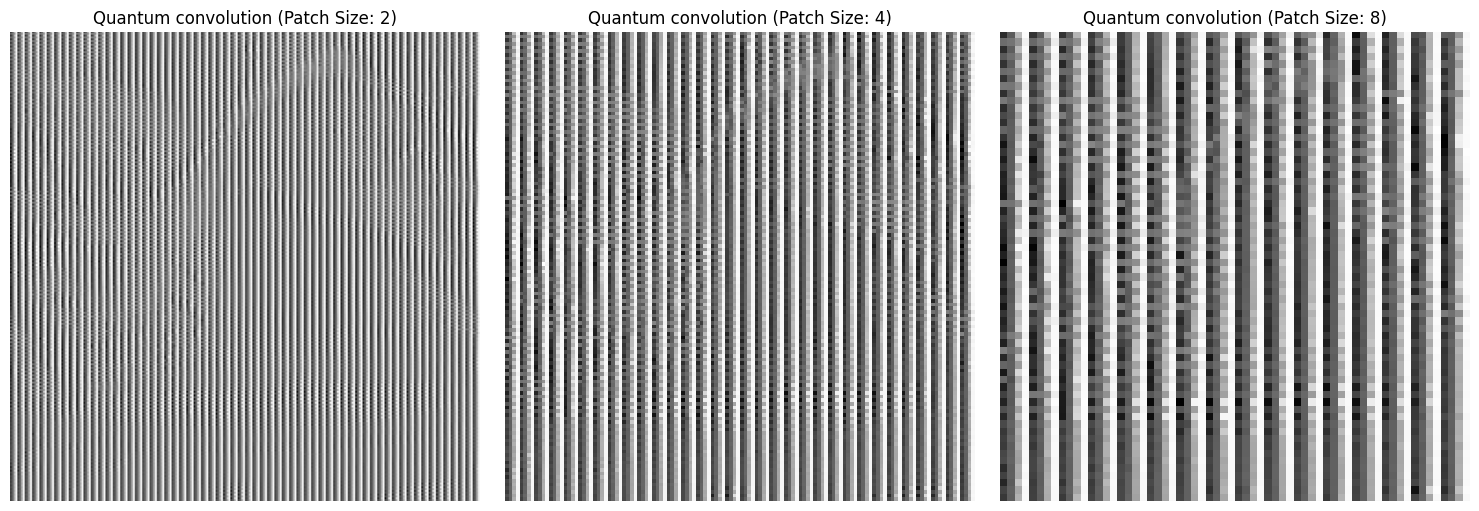

In [4]:
# Load a random image from the dataset
data_loader = DataLoader(dataset, batch_size=1, shuffle=True)
image, label = next(iter(data_loader))
print("Img shape:{}".format(image.shape))
assert image.shape[0] == rgb_c, "The image channel dimension does not match the specified rgb_c"
H, W = img_w, img_w
# print("Img H:{}".format(H))

# Original Image
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(image.squeeze().cpu().numpy(), cmap="gray")
ax.set_title("Original Image")
ax.axis("off")

# Iterate through different patch sizes
patch_sizes = [2,4,8]

fig, axs = plt.subplots(1, len(patch_sizes), figsize=(15, 5))

for idx, patch_size in enumerate(patch_sizes):
    # Calculate the number of patches
    num_patches_h = (H - patch_size + 1) // patch_size
    num_patches_w = (W - patch_size + 1) // patch_size
    total_patches = num_patches_h * num_patches_w
    print("Patch Size: {}, Total Patches: {}".format(patch_size, total_patches))

    # Accumulate results
    results = torch.empty((H // patch_size, W // patch_size, n_qubits))

    # Iterate through the image using patches of size patch_size * patch_size
    for i in range(0, H - patch_size + 1, patch_size):
        for j in range(0, W - patch_size + 1, patch_size):
            patch = image[:, :, i:i+patch_size, j:j+patch_size]
            patch = patch.to(device)
            # Reshape the patch tensor to match the expected shape for the quantum circuit
            inputs = patch.flatten()
            # Call the quantum circuit and collect the results
            exp_vals = CONVCircuit(inputs, phi_pqc_array, n_qubits, n_layers).float()
            # Assign the results to the corresponding position in the tensor
            results[i // patch_size, j // patch_size] = exp_vals.clone().detach()

    # Reshape results into a square shape
    results = results.reshape(((H // patch_size)*2, (H // patch_size)*2))

    # Plot the resulting quantum circuit
    axs[idx].imshow(results.squeeze().cpu().numpy(), cmap="gray")
    axs[idx].set_title("Quantum convolution (Patch Size: {})".format(patch_size))
    axs[idx].axis("off")

plt.tight_layout()
plt.show()
